#PhlyGreen Tutorial 

Import packages

In [67]:
import sys
sys.path.insert(0,'../')
import PhlyGreen as pg
import numpy as np
import matplotlib.pyplot as plt

Create instances of subsystems. Each one of those requires an Aircraft object as argument. By passing (None) as argument, we are creating empty objects (for the moment).

In [68]:
powertrain = pg.Systems.Powertrain.Powertrain(None)
structures = pg.Systems.Structures.Structures(None)
aerodynamics = pg.Systems.Aerodynamics.Aerodynamics(None)
performance = pg.Performance.Performance(None)
mission = pg.Mission.Mission(None)
weight = pg.Weight.Weight(None)
constraint = pg.Constraint.Constraint(None)
welltowake = pg.WellToWake.WellToWake(None)

Create instance of Aircraft object.

In [69]:
myaircraft = pg.Aircraft(powertrain, structures, aerodynamics, performance, mission, weight, constraint, welltowake)

Create the connections with its subsystems.

In [70]:
powertrain.aircraft = myaircraft
structures.aircraft = myaircraft
aerodynamics.aircraft = myaircraft
mission.aircraft = myaircraft
performance.aircraft = myaircraft
weight.aircraft = myaircraft
constraint.aircraft = myaircraft
welltowake.aircraft = myaircraft

Define input dictionaries

In [71]:
ConstraintsInput = {'DISA': 0.,
                    'Cruise': {'Speed': 0.5, 'Speed Type':'Mach', 'Beta': 0.95, 'Altitude': 8000.},
                    'AEO Climb': {'Speed': 210, 'Speed Type':'KCAS', 'Beta': 0.97, 'Altitude': 6000., 'ROC': 5},
                    'OEI Climb': {'Speed': 1.2*34.5, 'Speed Type': 'TAS', 'Beta': 1., 'Altitude': 0., 'Climb Gradient': 0.021},
                    'Take Off': {'Speed': 90, 'Speed Type': 'TAS', 'Beta': 1., 'Altitude': 100., 'kTO': 1.2, 'sTO': 950},
                    'Landing':{'Speed': 59., 'Speed Type': 'TAS', 'Altitude': 500.},
                    'Turn':{'Speed': 210, 'Speed Type': 'KCAS', 'Beta': 0.9, 'Altitude': 5000, 'Load Factor': 1.1},
                    'Ceiling':{'Speed': 0.5, 'Beta': 0.8, 'Altitude': 9500, 'HT': 0.5},
                    'Acceleration':{'Mach 1': 0.3, 'Mach 2':0.4, 'DT': 180, 'Altitude': 6000, 'Beta': 0.9}}

In [72]:
MissionInput = {'Range Mission': 750,  #nautical miles
                'Range Diversion': 220,  #nautical miles
                'Beta start': 0.97,
                'Payload Weight': 4560,  #Kg
                'Crew Weight': 500}  #Kg

In [73]:
MissionStages = {'Takeoff': {'Supplied Power Ratio':{'phi': 0.05}},
                'Climb1': {'type': 'ConstantRateClimb', 'input': {'CB': 0.16, 'Speed': 77, 'StartAltitude': 100, 'EndAltitude': 1500}, 'Supplied Power Ratio':{'phi_start': 0.0, 'phi_end':0.0 }},
                 'Climb2': {'type': 'ConstantRateClimb', 'input': {'CB': 0.08, 'Speed': 120, 'StartAltitude': 1500, 'EndAltitude': 4500}, 'Supplied Power Ratio':{'phi_start': 0.0, 'phi_end':0.0 }},
                 'Climb3': {'type': 'ConstantRateClimb', 'input': {'CB': 0.07, 'Speed': 125, 'StartAltitude': 4500, 'EndAltitude': 8000}, 'Supplied Power Ratio':{'phi_start': 0.0, 'phi_end':0.0 }},
                 'Cruise': {'type': 'ConstantMachCruise', 'input':{ 'Mach': 0.4, 'Altitude': 8000}, 'Supplied Power Ratio':{'phi_start': 0.0, 'phi_end':0.0 }},
                 'Descent1': {'type': 'ConstantRateDescent', 'input':{'CB': -0.04, 'Speed': 90, 'StartAltitude': 8000, 'EndAltitude': 200}, 'Supplied Power Ratio':{'phi_start': 0.0, 'phi_end':0.0 }}}

DiversionStages = {'Climb1': {'type': 'ConstantRateClimb', 'input': {'CB': 0.08, 'Speed': 110, 'StartAltitude': 200, 'EndAltitude': 3100}, 'Supplied Power Ratio':{'phi_start': 0.0, 'phi_end':0.0 }},
                 'Cruise': {'type': 'ConstantMachCruise', 'input':{ 'Mach': 0.35, 'Altitude': 3100}, 'Supplied Power Ratio':{'phi_start': 0.0, 'phi_end':0.0}},
                 'Descent1': {'type': 'ConstantRateDescent', 'input':{'CB': -0.04, 'Speed': 90, 'StartAltitude': 3100, 'EndAltitude': 200}, 'Supplied Power Ratio':{'phi_start': 0.0, 'phi_end':0.0 }}}


In [74]:
EnergyInput = {'Ef': 43.5*10**6,
                   'Ebat': 700 * 3600,
                   'pbat': 1000,
                   'Eta Gas Turbine': 0.22,
                   'Eta Gearbox': 0.96,
                   'Eta Propulsive': 0.9,
                   'Eta Electric Motor 1': 0.96,    #for serial config
                   'Eta Electric Motor 2': 0.96,    #for serial config
                   'Eta Electric Motor': 0.98,      #for parallel config
                   'Eta PMAD': 0.99,
                   'Specific Power Powertrain': [3900,7700],
                   'Specific Power PMAD': [2200,2200,2200],
                   'PowertoWeight Battery': 35, 
                   'PowertoWeight Powertrain': [150,33],
                   'PowertoWeight PMAD': 0
                   }

In [75]:
AerodynamicsInput = {'AnalyticPolar': {'type': 'Quadratic', 'input': {'AR': 11, 'e_osw': 0.8}},
                    'Take Off Cl': 1.9,
                     'Landing Cl': 1.9,
                     'Minimum Cl': 0.20,
                     'Cd0': 0.017}


Import input dictionaries

In [76]:
myaircraft.ConstraintsInput = ConstraintsInput
myaircraft.AerodynamicsInput = AerodynamicsInput
myaircraft.MissionInput = MissionInput
myaircraft.MissionStages = MissionStages
myaircraft.DiversionStages = DiversionStages
myaircraft.EnergyInput = EnergyInput

Set aircraft power configuration

In [77]:
myaircraft.Configuration = 'Hybrid'
myaircraft.HybridType = 'Parallel'

Set inputs

In [78]:
# Initialize Constraint Analysis
myaircraft.constraint.SetInput()

# Initialize Mission profile and Analysis
myaircraft.mission.InitializeProfile()
myaircraft.mission.SetInput()

# Initialize Aerodynamics subsystem
myaircraft.aerodynamics.SetInput()

# Initialize Powertrain
myaircraft.powertrain.SetInput()

# Initialize Weight Estimator
myaircraft.weight.SetInput()

500


Either run the Constraint Analysis....

In [79]:
myaircraft.constraint.FindDesignPoint()
print('----------------------------------------')
print('Design W/S: ',myaircraft.DesignWTOoS)
print('Design P/W: ',myaircraft.DesignPW)
print('----------------------------------------')

----------------------------------------
Design W/S:  3293.8228228228227
Design P/W:  194.90567908431782
----------------------------------------


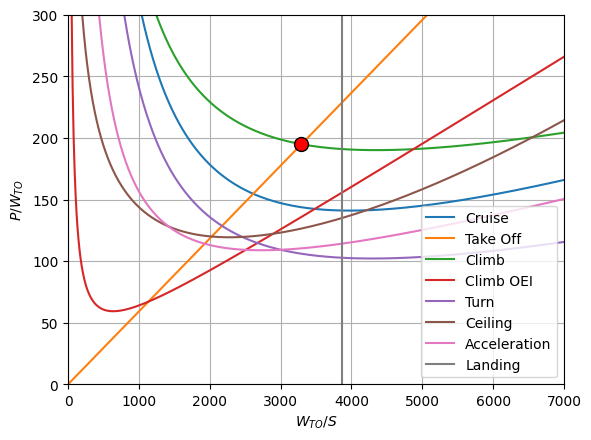

In [80]:
plt.plot(myaircraft.constraint.WTOoS,myaircraft.constraint.PWCruise, label='Cruise')
plt.plot(myaircraft.constraint.WTOoS,myaircraft.constraint.PWTakeOff, label='Take Off')
plt.plot(myaircraft.constraint.WTOoS,myaircraft.constraint.PWAEOClimb, label='Climb')
plt.plot(myaircraft.constraint.WTOoS,myaircraft.constraint.PWOEIClimb, label='Climb OEI')
plt.plot(myaircraft.constraint.WTOoS,myaircraft.constraint.PWTurn, label='Turn')
plt.plot(myaircraft.constraint.WTOoS,myaircraft.constraint.PWCeiling, label='Ceiling')
plt.plot(myaircraft.constraint.WTOoS,myaircraft.constraint.PWAcceleration, label='Acceleration')
plt.plot(myaircraft.constraint.WTOoSLanding,myaircraft. constraint.PWLanding, label='Landing')
plt.plot(myaircraft.DesignWTOoS, myaircraft.DesignPW, marker='o', markersize = 10, markerfacecolor = 'red', markeredgecolor = 'black')
# plt.plot(performance.WTOoSTorenbeek, performance.PWTorenbeek, label='Torenbeek')
plt.ylim([0, 300])
plt.xlim([0, 7000])
plt.legend()
plt.grid(visible=True)
plt.xlabel('$W_{TO}/S$')
plt.ylabel('$P/W_{TO}$')
plt.show()

... or assign a wing loading

In [81]:
# myaircraft.DesignWTOoS = 3323

Run Mission analysis to define the aircraft's masses

In [82]:
myaircraft.weight.WeightEstimation()

Wing surface can be readily estimated as S = WTO/(WTO/S)

In [83]:
myaircraft.WingSurface = myaircraft.weight.WTO / myaircraft.DesignWTOoS * 9.81

A summary of the preliminary design:

In [84]:
print('Fuel mass (trip + altn) [Kg]: ', myaircraft.weight.Wf)
print('Block Fuel mass [Kg]:         ', myaircraft.weight.Wf + myaircraft.weight.final_reserve)
print('Battery mass [Kg]:            ', myaircraft.weight.WBat)
print('Structure [Kg]:               ', myaircraft.weight.WStructure)
print('Powertrain mass [Kg]:         ',myaircraft.weight.WPT)
print('Empty Weight [Kg]:            ', myaircraft.weight.WPT + myaircraft.weight.WStructure + myaircraft.weight.WCrew + myaircraft.weight.WBat)
print('Zero Fuel Weight [Kg]:        ', myaircraft.weight.WPT + myaircraft.weight.WStructure + myaircraft.weight.WCrew + myaircraft.weight.WBat + myaircraft.weight.WPayload)
print('----------------------------------------')
print('Takeoff Weight: ', myaircraft.weight.WTO)
if myaircraft.WellToTankInput is not None:
    print('Source Energy: ', myaircraft.welltowake.SourceEnergy/1.e6,' MJ')
    print('Psi: ', myaircraft.welltowake.Psi)
print('Wing Surface: ', myaircraft.WingSurface, ' m^2')
print('TakeOff engine shaft peak power [kW]:      ', myaircraft.mission.TO_PP/1000.)
print('Climb/cruise engine shaft peak power [kW]: ', myaircraft.mission.Max_PEng/1000.)
print('TakeOff battery peak power [kW]:           ', myaircraft.mission.TO_PBat/1000.)
print('Climb/cruise battery peak power [kW]:      ', myaircraft.mission.Max_PBat/1000.)
print('Sizing phase for battery: ', 'Cruise energy' if myaircraft.weight.WBatidx == 0 else 'Cruise peak power' if myaircraft.weight.WBatidx == 1 else 'Takeoff peak power'  )
print('Sizing phase for thermal powertrain ', 'Climb/Cruise peak power' if myaircraft.mission.Max_PEng > myaircraft.mission.TO_PP else 'Takeoff peak power'  )
print('Sizing phase for electric powertrain ', 'Climb/Cruise peak power' if myaircraft.mission.Max_PBat > myaircraft.mission.TO_PBat else 'Takeoff peak power'  )

Fuel mass (trip + altn) [Kg]:  2419.674812570436
Block Fuel mass [Kg]:          2549.674812570436
Battery mass [Kg]:             943.3126200955289
Structure [Kg]:                11836.276422232217
Powertrain mass [Kg]:          1148.8305621220004
Empty Weight [Kg]:             14428.419604449746
Zero Fuel Weight [Kg]:         18988.419604449744
----------------------------------------
Takeoff Weight:  21538.058090653423
Wing Surface:  64.14684736692513  m^2
TakeOff engine shaft peak power [kW]:       3943.0467519993103
Climb/cruise engine shaft peak power [kW]:  4002.65747560404
TakeOff battery peak power [kW]:            943.3126200955289
Climb/cruise battery peak power [kW]:       0.0
Sizing phase for battery:  Takeoff peak power
Sizing phase for thermal powertrain  Climb/Cruise peak power
Sizing phase for electric powertrain  Takeoff peak power


Some plots:

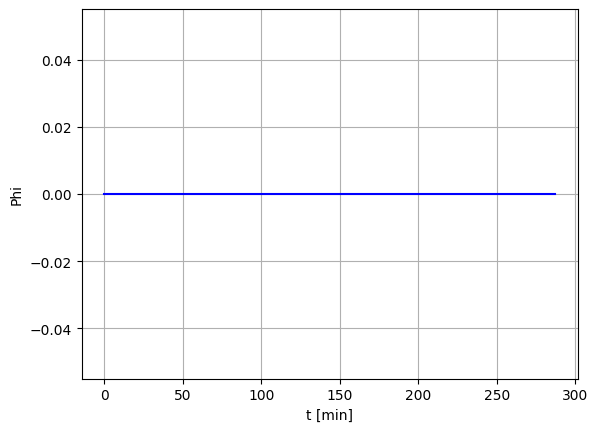

In [85]:
times = np.linspace(0,mission.profile.MissionTime2,num = 1000)
plt.plot(times/60,[mission.profile.SuppliedPowerRatio(t) for t in times], 'b')
#plt.plot(myaircraft.mission.profile.Breaks,np.ones(6)*0.05, '*')
plt.grid(visible=True)
plt.xlabel('t [min]')
plt.ylabel('Phi')
plt.show()

In [86]:
times = np.array([])
Ef = np.array([])
Ebat = np.array([])
beta = np.array([])
for array in mission.integral_solution:
    times = np.concatenate([times, array.t])
    Ef = np.concatenate([Ef, array.y[0]])
    Ebat = np.concatenate([Ebat, array.y[1]])
    beta = np.concatenate([beta, array.y[2]])

Takeoff propulsive power

In [87]:
myaircraft.performance.TakeOff(myaircraft.DesignWTOoS,myaircraft.constraint.TakeOffConstraints['Beta'], myaircraft.constraint.TakeOffConstraints['Altitude'],myaircraft.constraint.TakeOffConstraints['kTO'], myaircraft.constraint.TakeOffConstraints['sTO'], myaircraft.constraint.DISA, myaircraft.constraint.TakeOffConstraints['Speed'], myaircraft.constraint.TakeOffConstraints['Speed Type'])

194.88837279163596

Maximum mission Propusive Power over Takeoff Mass

In [88]:
max([myaircraft.performance.PoWTO(myaircraft.DesignWTOoS,beta[t],myaircraft.mission.profile.PowerExcess(times[t]),1,myaircraft.mission.profile.Altitude(times[t]),myaircraft.mission.DISA,myaircraft.mission.profile.Velocity(times[t]),'TAS') for t in range(len(times))])

160.56638049943834

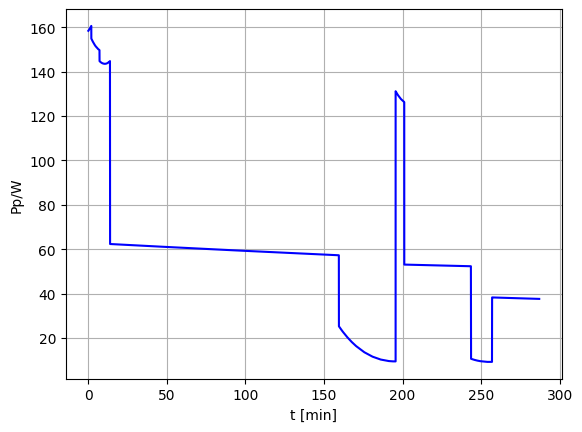

In [89]:
plt.plot(times/60,[myaircraft.performance.PoWTO(myaircraft.DesignWTOoS,beta[t],myaircraft.mission.profile.PowerExcess(times[t]),1,myaircraft.mission.profile.Altitude(times[t]),myaircraft.mission.DISA,myaircraft.mission.profile.Velocity(times[t]),'TAS') for t in range(len(times))], 'b')
plt.grid(visible=True)
plt.xlabel('t [min]')
plt.ylabel('Pp/W')
plt.show()

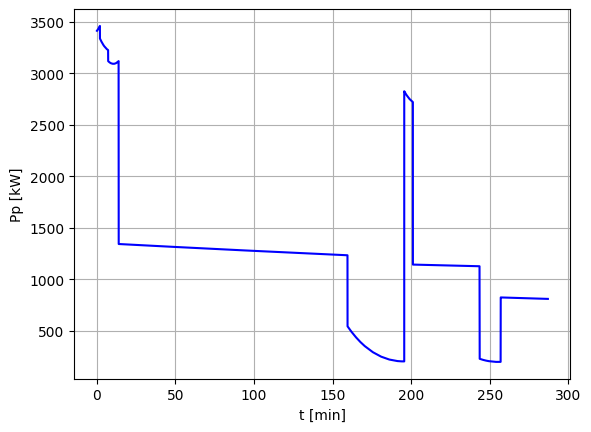

In [90]:
plt.plot(times/60,[(myaircraft.weight.WTO/1000) * myaircraft.performance.PoWTO(myaircraft.DesignWTOoS,beta[t],myaircraft.mission.profile.PowerExcess(times[t]),1,myaircraft.mission.profile.Altitude(times[t]),myaircraft.mission.DISA,myaircraft.mission.profile.Velocity(times[t]),'TAS') for t in range(len(times))], 'b')
plt.grid(visible=True)
plt.xlabel('t [min]')
plt.ylabel('Pp [kW]')
plt.show()

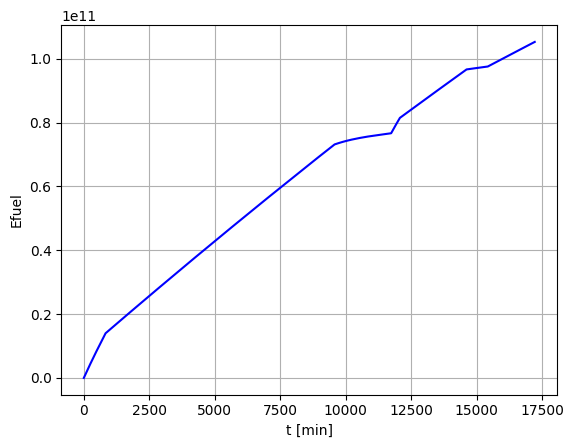

In [91]:
plt.plot(times,Ef, 'b')
#plt.plot(myaircraft.mission.profile.Breaks,np.ones(6)*0.05, '*')
plt.grid(visible=True)
plt.xlabel('t [min]')
plt.ylabel('Efuel')
plt.show()

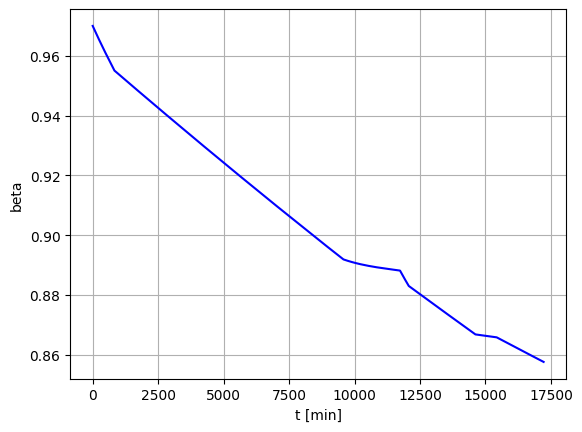

In [92]:
plt.plot(times,beta, 'b')
#plt.plot(myaircraft.mission.profile.Breaks,np.ones(6)*0.05, '*')
plt.grid(visible=True)
plt.xlabel('t [min]')
plt.ylabel('beta')
plt.show()

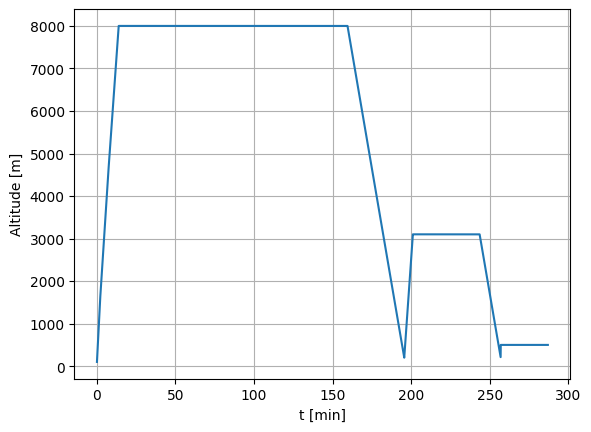

In [93]:
plt.plot(times/60,mission.profile.Altitude(times))
plt.grid(visible=True)
plt.xlabel('t [min]')
plt.ylabel('Altitude [m]')
plt.show()